## DVD Inversion exercise (InSAR- High Noise)

This notebook solves DVD inversion exercise using the InSAR datasets

## Import libraries

In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib
import h5py
from vmod import util
from vmod.data import Insar
from vmod.data import Joint
from vmod.source import Mctigue

## Read dataset

In [2]:
xsa,ysa,losa,azsa,incsa=np.loadtxt('examples/dvd/insar/Synth_Asc_High_Correlated.csv',skiprows=1,delimiter=',',unpack=True)
xsd,ysd,losd,azsd,incsd=np.loadtxt('examples/dvd/insar/Synth_Des_High_Correlated.csv',skiprows=1,delimiter=',',unpack=True)
azsa=np.radians(azsa)
azsd=np.radians(azsd)
incsa=np.radians(incsa)
incsd=np.radians(incsd)

In [3]:
nx=401
ny=nx
losaor=np.reshape(losa,(ny,nx))[:,::-1].T
losdor=np.reshape(losd,(ny,nx))[:,::-1].T
azsa=np.reshape(azsa,(ny,nx))[:,::-1].T
azsd=np.reshape(azsd,(ny,nx))[:,::-1].T
incsa=np.reshape(incsa,(ny,nx))[:,::-1].T
incsd=np.reshape(incsd,(ny,nx))[:,::-1].T

In [4]:
extenta=[np.min(xsa),np.max(xsa),np.min(ysa),np.max(ysa)]
extentd=[np.min(xsd),np.max(xsd),np.min(ysd),np.max(ysd)]
#util.mat2quad(losa,azsa,incsa,extenta,name='asc_low.txt',per=15,unit='m')
#util.mat2quad(losd,azsd,incsd,extentd,name='des_low.txt',per=15,unit='m')

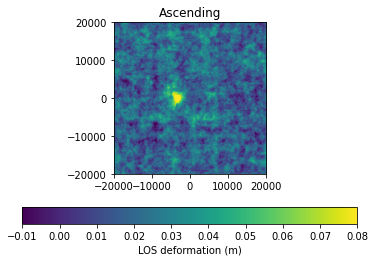

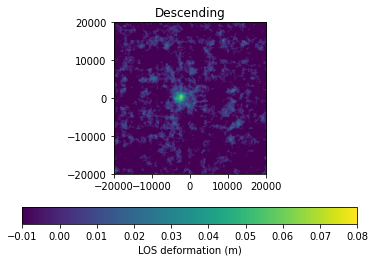

In [5]:
plt.figure()
plt.title('Ascending')
plt.imshow(losaor,extent=extenta,vmin=-0.01,vmax=0.08)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

plt.figure()
plt.title('Descending')
plt.imshow(losdor,extent=extentd,vmin=-0.01,vmax=0.08)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

In [6]:
util.quadtree_var(losaor,azsa,incsa,extent=[-20000,20000,-20000,20000],th=np.nanvar(losa)/50,name='examples/dvd/insar/asc_high.txt')
util.quadtree_var(losdor,azsd,incsd,extent=[-20000,20000,-20000,20000],th=np.nanvar(losd)/50,name='examples/dvd/insar/des_high.txt')

Final samples:  2146
Final samples:  2029


## Reading downsampled data

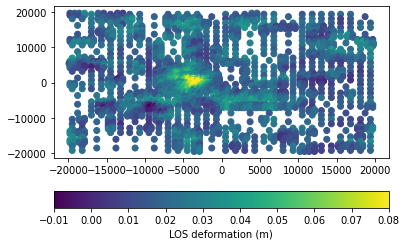

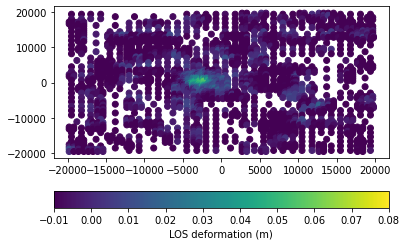

In [7]:
import numpy as np

xsa,ysa,azsa,lksa,losa,elosa,refa=util.read_insar_csv('examples/dvd/insar/asc_high.txt',cref=False)
xsd,ysd,azsd,lksd,losd,elosd,refd=util.read_insar_csv('examples/dvd/insar/des_high.txt',cref=False)

plt.figure()
plt.scatter(xsa,ysa,c=losa,vmin=-0.01,vmax=0.08)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

plt.figure()
plt.scatter(xsd,ysd,c=losd,vmin=-0.01,vmax=0.08)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

## Create data object

In [8]:
obsa=Insar()
obsa.add_xs(xsa)
obsa.add_ys(ysa)
obsa.add_vecs(azsa,lksa)
obsa.add_los(losa)
obsa.add_err(elosa)

obsd=Insar()
obsd.add_xs(xsd)
obsd.add_ys(ysd)
obsd.add_vecs(azsd,lksd)
obsd.add_los(losd)
obsd.add_err(elosd)

obs=Joint()
obs.add_dataset(obsa)
obs.add_dataset(obsd)

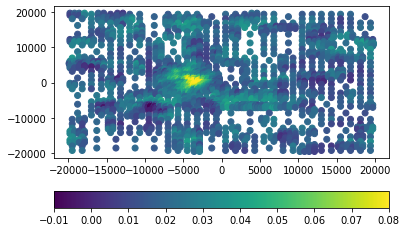

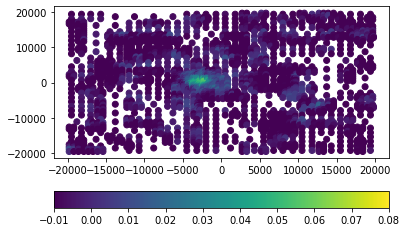

In [9]:
plt.figure()
plt.scatter(xsa,ysa,c=obsa.get_data(),vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsd,ysd,c=obsd.get_data(),vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

## Create model objects for each direction

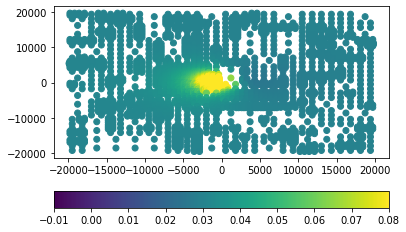

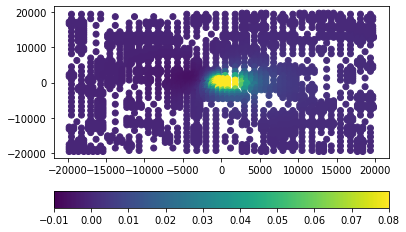

In [10]:
mcta=Mctigue(obsa)
mcta.add_offsets()
losm=mcta.forward([0,0,2.0e3,1.5e3,1e6,0.03])

plt.figure()
plt.scatter(xsa,ysa,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

mctd=Mctigue(obsd)
mctd.add_offsets()
losm=mctd.forward([0,0,2.0e3,1.5e3,1e6,0])

plt.figure()
plt.scatter(xsd,ysd,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

## Create object model for joint data

In [11]:
mct=Mctigue(obs)
mct.add_offsets()
mct.set_x0([0,0,2e3,5e2,1e6,0.03,0])
#Bounds for parameters
mct.set_bounds(low_bounds = [-20000,-20000,1e2,1e2,1e5,0,-0.1], high_bounds = [20000,20000,9e4,5e3,1e8,0.1,0])

## Create Inversion object

In [12]:
from vmod.inverse import Inverse

inv=Inverse(obs)
inv.register_source(mct)

## Least-squares inversion

In [13]:
ans=inv.nlsq()

print(ans.x)

/home/jovyan/notebooks/ASF/vmod_beta4/vmod/data/insar.py:113: RuntimeWarning: invalid value encountered in subtract
  los=ux*np.sin(self.inc)*np.cos(self.az)-uy*np.sin(self.inc)*np.sin(self.az)-uz*np.cos(self.inc)


0.0719949216663822
[-3.10425872e+03  1.56585787e+02  2.13284939e+03  2.13284768e+03
  1.10022457e+05  1.87468478e-02 -1.06280228e-02]


## Forward model with least squares solution

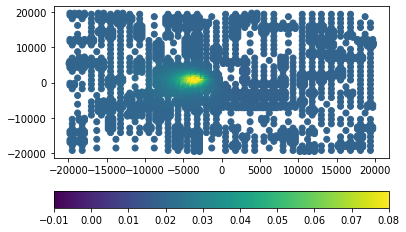

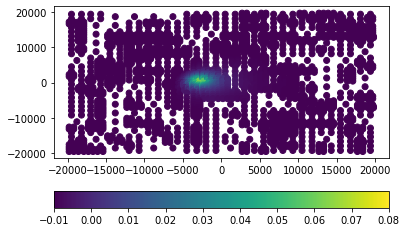

In [16]:
ansa=ans.x[0:len(ans.x)-1]
ansd=np.concatenate((ans.x[0:len(ans.x)-2],[ans.x[-1]]))

losm=mcta.forward(ansa)

plt.figure()
plt.scatter(xsa,ysa,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

losm=mctd.forward(ansd)

plt.figure()
plt.scatter(xsd,ysd,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

## Bayesian inversion

In [17]:
trace,MDL=inv.mcmc('insar_high_off_dP')

 [-                 2%                  ] 32940 of 1100000 complete in 285.4 sec

/home/jovyan/notebooks/ASF/vmod_beta4/vmod/data/insar.py:113: RuntimeWarning: invalid value encountered in subtract
  los=ux*np.sin(self.inc)*np.cos(self.az)-uy*np.sin(self.inc)*np.sin(self.az)-uz*np.cos(self.inc)


 [-----------------100%-----------------] 1100000 of 1100000 complete in 6121.3 sec

In [14]:
import pickle

with open('insar_high_off_dP.pkl','rb') as handle:
    dic=pickle.load(handle)

trace=[dic[key] for key in dic.keys()]

In [23]:
print(trace[-1])

[-0.01081504 -0.01025457 -0.01068166 ... -0.01065632 -0.01058273
 -0.01058273]


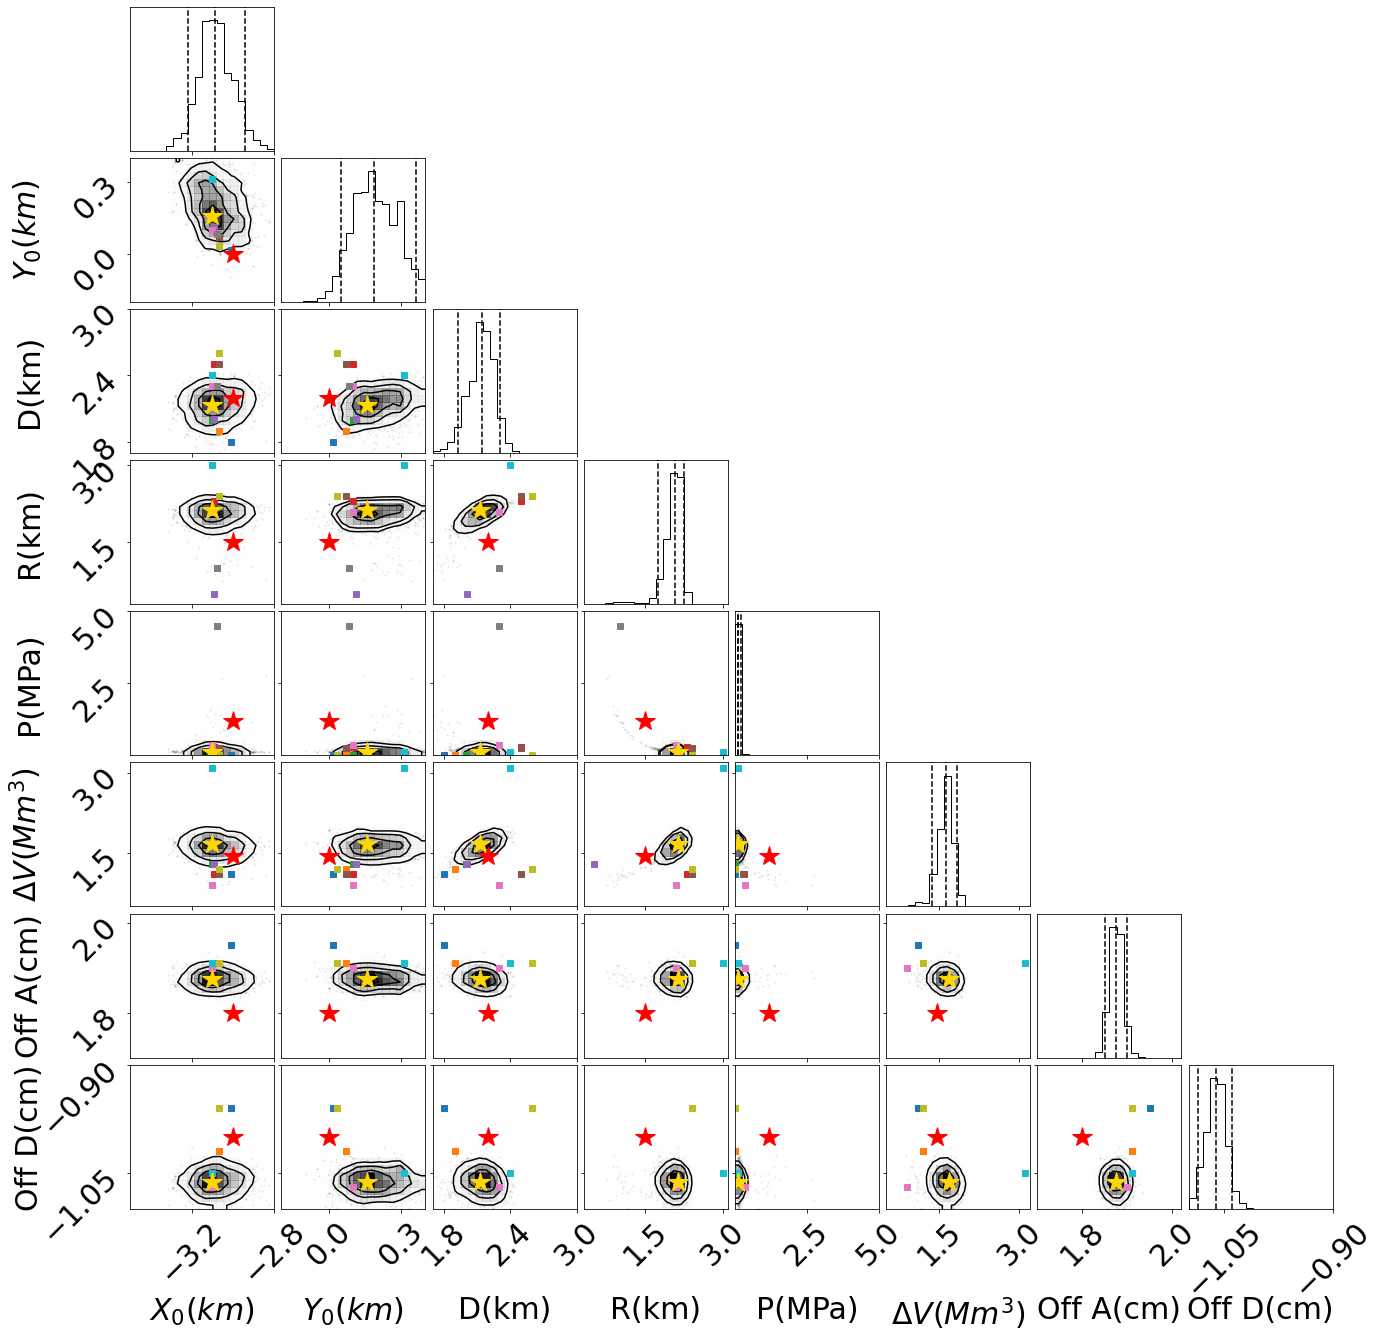

In [15]:
%matplotlib inline
data=[]
labels=[]
parnames,orders=inv.get_parnames_orders()
for i,tr in enumerate(trace):
    data.append(tr[:])
    labels.append(parnames[i])
data=np.vstack(data)
newdata=np.zeros((data.shape[0]+1,data.shape[1]))
newdata[:,:]=np.nan
newdata[0:4,:]=np.copy(data[0:4,:])
#newdata[4,:]=np.copy(data[4,:]*2e10/(np.pi*data[3,:]**3))
newdata[5,:]=np.copy((data[4,:]*(np.pi*data[3,:]**3)/4e9)*(1+(data[3,:]/data[2,:])**4))
newdata[4,:]=np.copy(data[4,:])
newdata[6::,:]=np.copy(data[5::,:])

data=np.copy(newdata)
data[0,:]=data[0,:]/1e3
data[1,:]=data[1,:]/1e3
data[2,:]=data[2,:]/1e3
data[3,:]=data[3,:]/1e3
data[4,:]=data[4,:]/1e6
data[5,:]=data[5,:]/1e6
data[6,:]=data[6,:]*1e2
data[7,:]=data[7,:]*1e2

labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$','D(km)','R(km)','P(MPa)','$\Delta{V} (Mm^{3})$','Off A(cm)','Off D(cm)']
trus1=[-3.01,0.017,1.80,0,0,1.1,1.95,-0.96]
trus2=[-3.07,0.07,1.90,0.0,0,1.2,1.91,-1.02]
trus3=[-3.10,0.10,2.00,0.0,0,1.3,0,0]
trus4=[-3.09,0.10,2.50,2.3,0.3,1.1,0,0]
trus5=[-3.09,0.11,2.01,0.5,30,1.3,0,0]
trus6=[-3.07,0.07,2.50,2.4,0.27,1.1,0,0]
trus7=[-3.10,0.10,2.30,2.1,0.35,0.9,1.9,-1.07]
trus8=[-3.08,0.08,2.30,1.0,4.5,0.0,0,0]
trus9=[-3.07,0.03,2.60,2.4,0,1.2,1.91,-0.96]
trus10=[-3.1,0.31,2.40,3.0,0.1,3.1,1.91,-1.05]

trus=[trus1,trus2,trus3,trus4,trus5,trus6,trus7,trus8,trus9,trus10]

ranges=[(-3.5,-2.8),(-0.2,0.4),(1.7,3.0),(0.3,3.1),(0,5),(0.5,3.2),(1.7,2.02),(-1.1,-0.9)]

ansx=[ans.x[0]/1e3,ans.x[1]/1e3,ans.x[2]/1e3,ans.x[3]/1e3,ans.x[4]/1e6,(ans.x[4]*np.pi*ans.x[3]**3/(4e9*1e6))*(1+(ans.x[3]/ans.x[2])**4),ans.x[5]*1e2,ans.x[6]*1e2]

true=[-3,0,2.2,1.5,1.2,1.45,1.8,-1.0]

plt.rcParams.update({'font.size': 30})
figure = corner.corner(data.T, labels=labels,
                       quantiles=[0.05, 0.5, 0.95],smooth=0.7,range=ranges,max_n_ticks=2,labelpad=0.3,
                       show_titles=False, label_kwargs={"fontsize": 30}, title_kwargs={"fontsize": 30})
for i,tru in enumerate(trus):
    #corner.overplot_lines(figure, tru, color="C"+str(i),linewidth=1)
    corner.overplot_points(figure, np.array(tru)[None], color="C"+str(i),marker='s')
corner.overplot_points(figure, np.array(ansx)[None], color="gold",marker='*',ms=20)
corner.overplot_points(figure, np.array(true)[None], color="red",marker='*',ms=20)
plt.savefig('histograms')

## Calculation of percentiles to upload the results

In [16]:
means=[np.percentile(data[i,:],50) for i in range(data.shape[0])]
lower95=[np.percentile(data[i,:],5)-np.percentile(data[i,:],50) for i in range(data.shape[0])]
upper95=[np.percentile(data[i,:],95)-np.percentile(data[i,:],50) for i in range(data.shape[0])]
lower32=[np.percentile(data[i,:],32) for i in range(data.shape[0])]
upper68=[np.percentile(data[i,:],68) for i in range(data.shape[0])]

results=[means,lower95,upper95,lower32,upper68]

for res in results:
    for i in range(len(res)):
        if i in [0,1,2,3]:
            res[i]=res[i]
        elif i in [4,5]:
            res[i]=res[i]
        elif i in [6,7]:
            res[i]=res[i]
    print("%.2f,%.2f,%.2f,%.2f,%.2f,%.2f,%.2f,%.2f"%(tuple(res)))

-3.09,0.19,2.14,2.08,0.12,1.63,1.88,-1.06
-0.13,-0.14,-0.21,-0.33,-0.02,-0.26,-0.02,-0.02
0.15,0.18,0.16,0.17,0.09,0.21,0.02,0.02
-3.12,0.15,2.09,2.00,0.11,1.56,1.87,-1.07
-3.05,0.24,2.20,2.13,0.14,1.68,1.88,-1.06


[-3.08714272e+03  1.86487959e+02  2.14384568e+03  2.07616779e+03
  1.22623940e+05  1.87514305e-02] [-3.08714272e+03  1.86487959e+02  2.14384568e+03  2.07616779e+03
  1.22623940e+05 -1.06155406e-02]


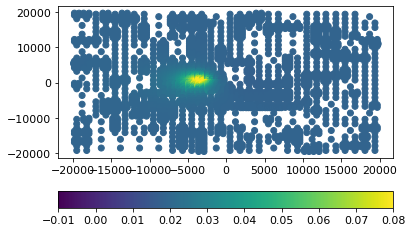

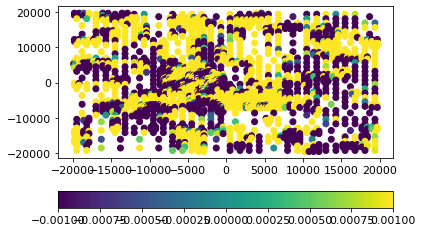

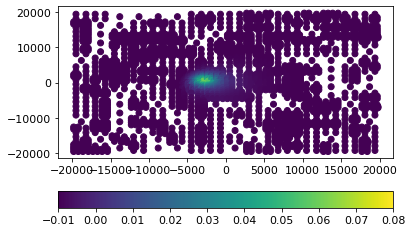

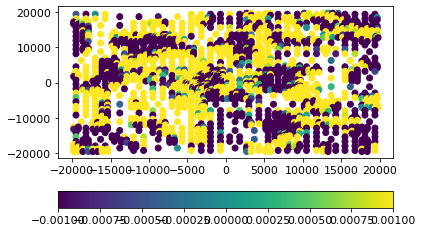

In [31]:
plt.rcParams.update({'font.size': 11})
ansa=np.concatenate((means[0:4],[means[4],means[6]]))
ansd=np.concatenate((means[0:4],[means[4],means[7]]))

print(ansa,ansd)

losma=mcta.forward(ansa)

plt.figure()
plt.scatter(xsa,ysa,c=losma,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsa,ysa,c=obsa.get_data()-losma,vmin=-1e-3,vmax=1e-3)
plt.colorbar(orientation='horizontal')

losmd=mctd.forward(ansd)

plt.figure()
plt.scatter(xsd,ysd,c=losmd,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsd,ysd,c=obsd.get_data()-losmd,vmin=-1e-3,vmax=1e-3)
plt.colorbar(orientation='horizontal')

Text(0, 0.5, 'Y(km)')

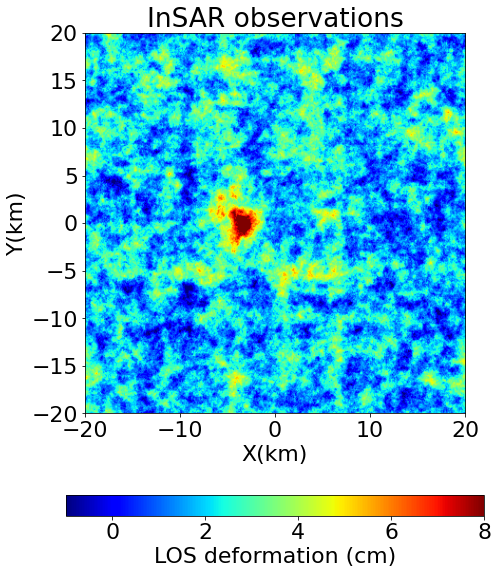

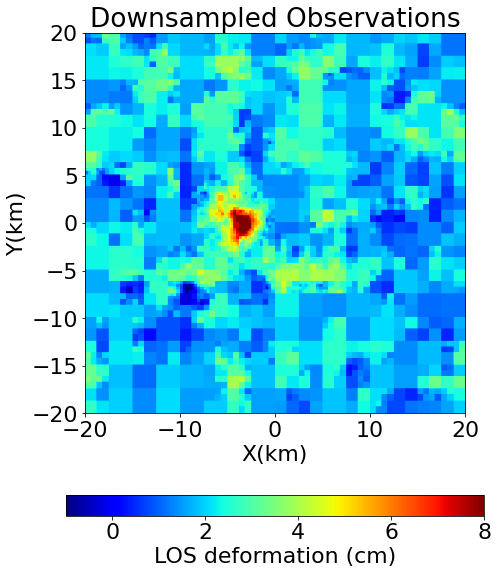

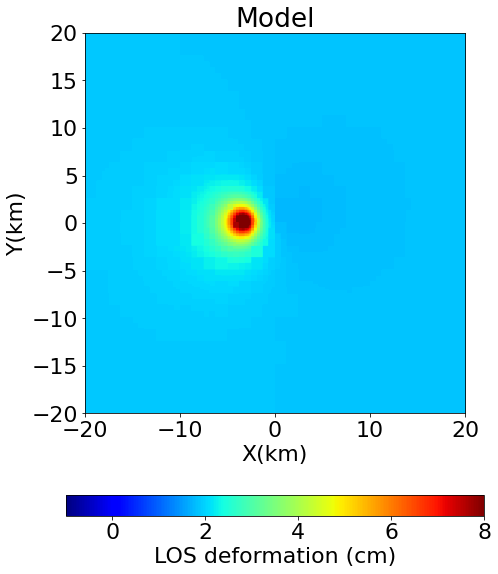

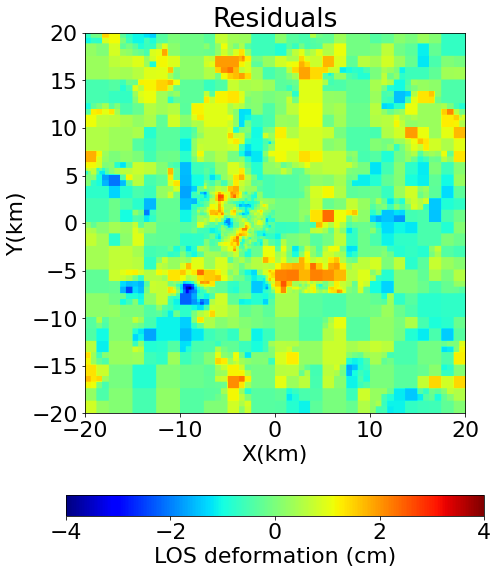

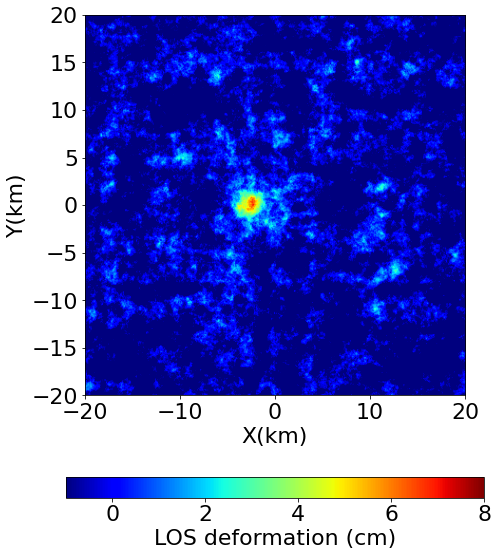

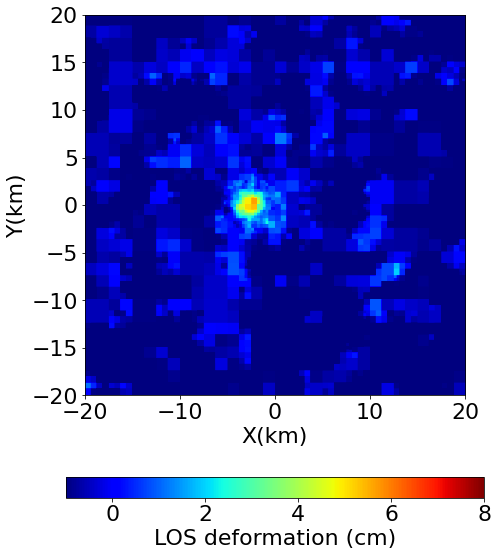

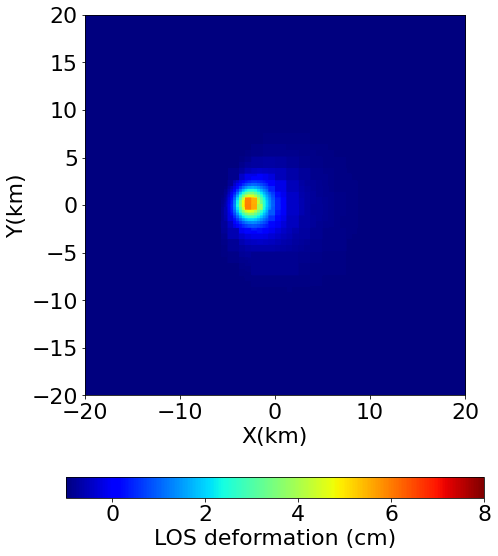

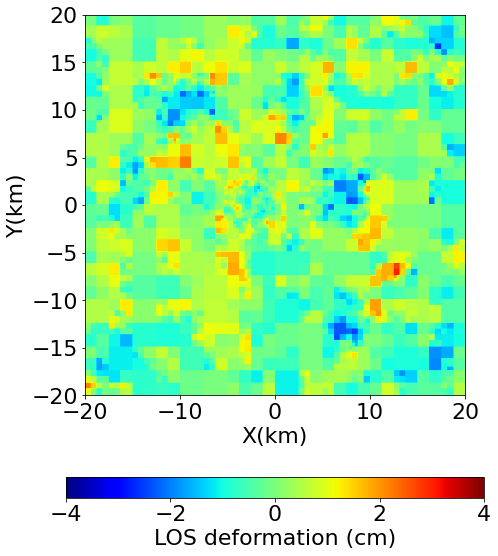

In [32]:
plt.rcParams.update({'font.size': 22})

qmapa,extent=util.los2npy(obsa.get_data(),'examples/dvd/insar/asc_high.txt',cref=False)

plt.figure(figsize=(10,10))
plt.title('InSAR observations')
plt.imshow(losaor*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
#plt.text(5,15,s='Ascending')
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
plt.title('Downsampled Observations')
plt.imshow(qmapa*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

qmapma,extent=util.los2npy(losma,'examples/dvd/insar/asc_high.txt',cref=False)

plt.figure(figsize=(10,10))
plt.title('Model')
plt.imshow(qmapma*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
plt.title('Residuals')
plt.imshow((qmapa-qmapma)*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-4,vmax=4,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

qmapd,extent=util.los2npy(obsd.get_data(),'examples/dvd/insar/des_high.txt',cref=False)

plt.figure(figsize=(10,10))
#plt.title('Observations')
plt.imshow(losdor*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
#plt.text(5,15,s='Descending',c='white')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
#plt.title('Downsampled observations')
plt.imshow(qmapd*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

qmapmd,extent=util.los2npy(losmd,'examples/dvd/insar/des_high.txt',cref=False)

plt.figure(figsize=(10,10))
#plt.title('Model')
plt.imshow(qmapmd*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
#plt.title('Residuals')
plt.imshow((qmapd-qmapmd)*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-4,vmax=4,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

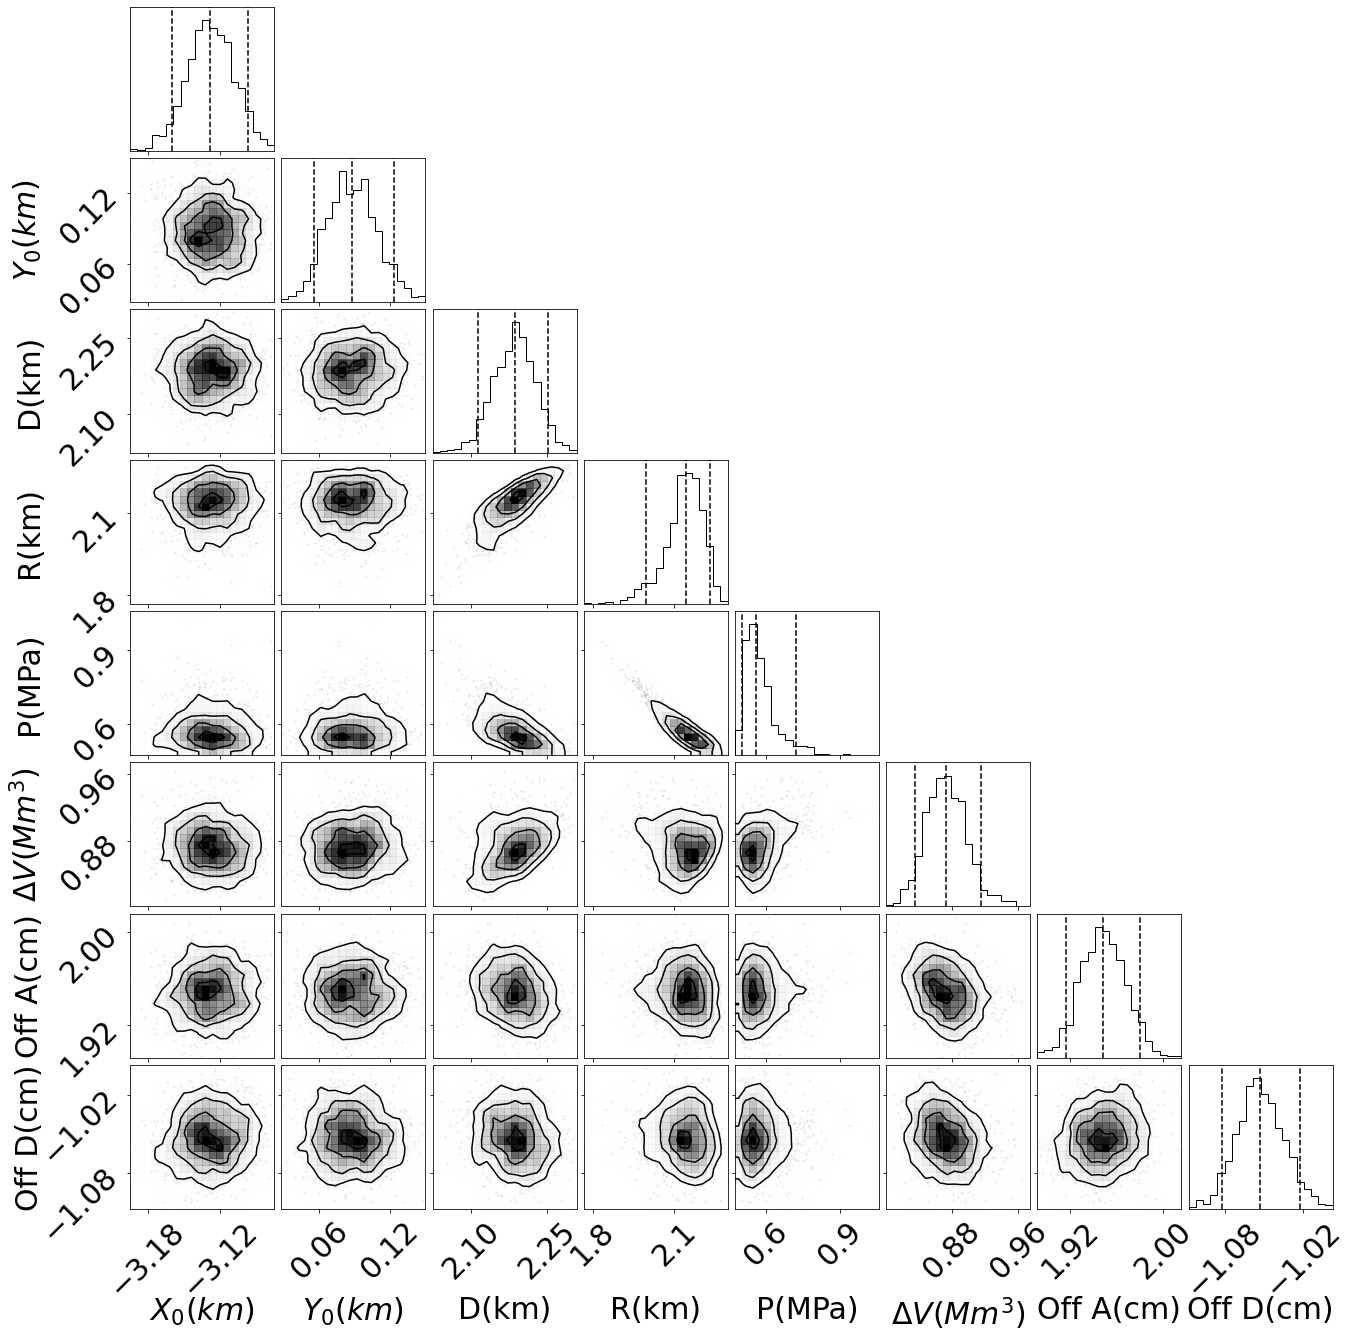

In [25]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

data=[]
labels=[]
parnames,orders=inv.get_parnames_orders()
for i,tr in enumerate(trace):
    data.append(tr[:])
    labels.append(parnames[i])
data=np.vstack(data)
newdata=np.zeros((data.shape[0]+1,data.shape[1]))
newdata[:,:]=np.nan
newdata[0:4,:]=np.copy(data[0:4,:])
newdata[4,:]=np.copy(data[4,:]*2e10/(np.pi*data[3,:]**3))
newdata[5::,:]=np.copy(data[4::,:])

data=np.copy(newdata)
data[0,:]=data[0,:]/1e3
data[1,:]=data[1,:]/1e3
data[2,:]=data[2,:]/1e3
data[3,:]=data[3,:]/1e3
data[4,:]=data[4,:]/1e6
data[5,:]=data[5,:]/1e6
data[6,:]=data[6,:]*1e2
data[7,:]=data[7,:]*1e2

labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$','D(km)','R(km)','P(MPa)','$\Delta{V} (Mm^{3})$','Off A(cm)','Off D(cm)']

#ranges=[(-3.5,-2.8),(-0.2,0.4),(1.7,3.0),(0.3,3.1),(0,5),(0.5,3.2),(1.87,2.02),(-1.1,-0.9)]

#ansx=[ans.x[0]/1e3,ans.x[1]/1e3,ans.x[2]/1e3,ans.x[3]/1e3,ans.x[4]*2e10/(1e6*np.pi*ans.x[3]**3),ans.x[4]/1e6,ans.x[5]*1e2,ans.x[6]*1e2]

plt.rcParams.update({'font.size': 30})
figure = corner.corner(data.T, labels=labels,
                       quantiles=[0.05, 0.5, 0.95],smooth=0.7,max_n_ticks=2,labelpad=0.3,
                       show_titles=False, label_kwargs={"fontsize": 30}, title_kwargs={"fontsize": 30})

#plt.savefig('histograms')
figure.savefig('histograms_insar_low.pdf', bbox_inches='tight', format='pdf')